✅ 최적 RF 파라미터: {'max_depth': 10, 'n_estimators': 400}

[모델 성능 요약]
R²(테스트): 0.625
교차검증 R² 평균: 0.603
RMSE: 0.470 | MAE: 0.305


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50696 (\N{HANGUL SYLLABLE YE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 52769 (\N{HANGUL SYLLABLE CEUG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51228 (\N{HANGUL SYLLABLE JE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


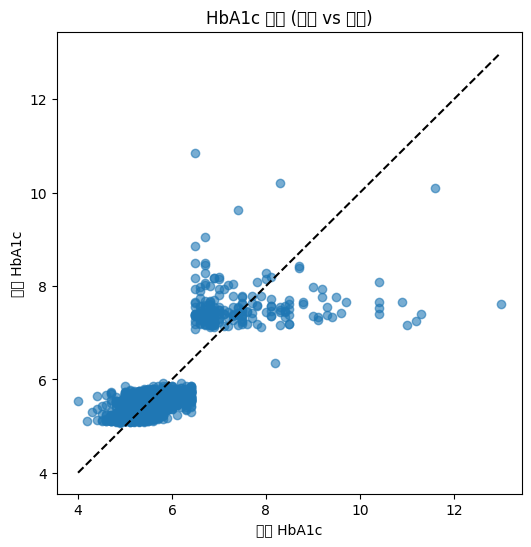

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51092 (\N{HANGUL SYLLABLE JAN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54540 (\N{HANGUL SYLLABLE PEUL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47215 (\N{HANGUL SYLLABLE ROS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44050 (\N{HANGUL SYLLABLE GABS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr

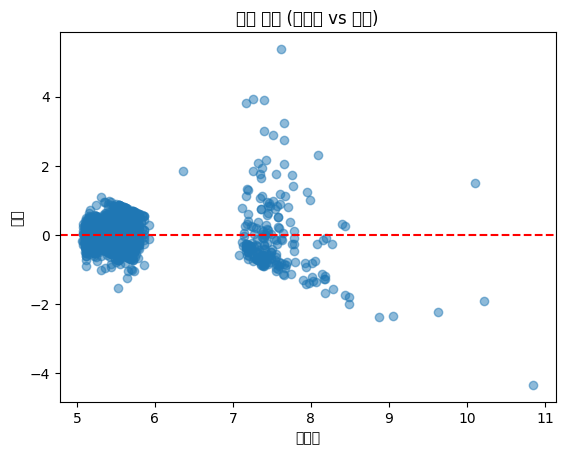

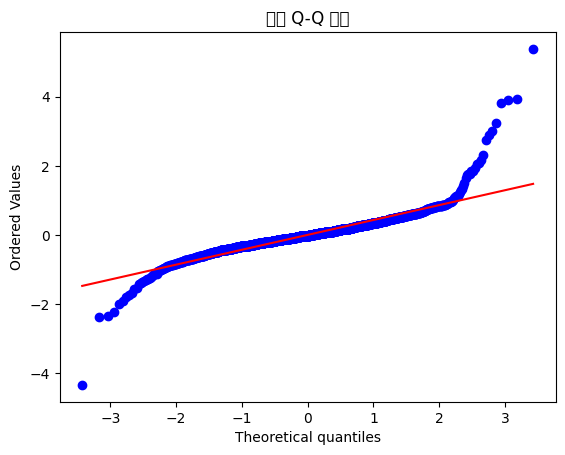

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45817 (\N{HANGUL SYLLABLE DANG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45544 (\N{HANGUL SYLLABLE NYO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50948 (\N{HANGUL SYLLABLE WI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54744 (\N{HANGUL SYLLABLE HEOM}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51473 (\N{HANGUL SYLLABLE JUNG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/us

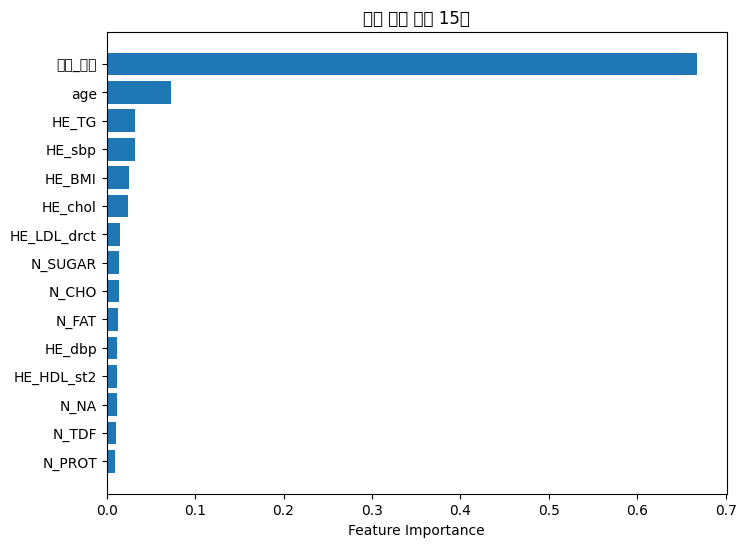


[해석 가이드]
- R²: 0.8 이상 → 예측력 우수. 단, 과적합 없이 교차검증 R²도 비슷해야 신뢰 가능.
- RMSE/MAE: HbA1c 단위(%)로, 0.3~0.4 수준이면 현실적으로 높은 예측력.
- 중요 변수: 나이, BMI, TG, LDL, 혈압, 당류 섭취량 등 → 임상적으로 타당해야 함.
- 잔차 패턴이 랜덤 → 특정 집단(성별, 나이)에 편향 없음.


In [2]:
# ============================================
# HbA1c 예측 회귀모델 (설명력 + 정확도 + 신뢰성 통합형)
# ============================================

import os, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, StackingRegressor, GradientBoostingRegressor
import scipy.stats as stats

# -------------------------------------------------------------
# 1) 데이터 로드
# -------------------------------------------------------------
DATA_PATH = '/content/modeling_dataset_hba1c_Excel.csv'
df = pd.read_csv(DATA_PATH, encoding='cp949')

# -------------------------------------------------------------
# 2) 타깃 설정 (HbA1c)
# -------------------------------------------------------------
target_col = [c for c in df.columns if 'hba1c' in c.lower()][0]
y = df[target_col].astype(float)

# -------------------------------------------------------------
# 3) 입력(X) 구성 - 누수 제거
# -------------------------------------------------------------
drop_cols = [c for c in df.columns if ('hba1c' in c.lower()) or ('_dm_' in c.lower())]
X = df.drop(columns=drop_cols, errors='ignore')
X = pd.get_dummies(X, columns=[c for c in ['sex','educ','incm','occp'] if c in X.columns], drop_first=True)

feature_names = X.columns.tolist()

# -------------------------------------------------------------
# 4) 데이터 분할
# -------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# -------------------------------------------------------------
# 5) 모델 정의
# -------------------------------------------------------------
ridge = Pipeline([
    ('scaler', StandardScaler()),
    ('reg', Ridge(alpha=1.0))
])

rf = RandomForestRegressor(random_state=42, n_jobs=-1)
param_grid = {'n_estimators':[200,400], 'max_depth':[10,20,None]}
grid = GridSearchCV(rf, param_grid, cv=3, scoring='r2', n_jobs=-1)
grid.fit(X_train, y_train)
best_rf = grid.best_estimator_
print("✅ 최적 RF 파라미터:", grid.best_params_)

# -------------------------------------------------------------
# 6) 스태킹 앙상블 (해석력 + 예측력 균형)
# -------------------------------------------------------------
stack_model = StackingRegressor(
    estimators=[('ridge', ridge), ('rf', best_rf)],
    final_estimator=GradientBoostingRegressor(n_estimators=200, learning_rate=0.05, max_depth=3, random_state=42),
    n_jobs=-1
)

# -------------------------------------------------------------
# 7) 학습 및 예측
# -------------------------------------------------------------
stack_model.fit(X_train, y_train)
pred = stack_model.predict(X_test)

# -------------------------------------------------------------
# 8) 평가 지표
# -------------------------------------------------------------
rmse = np.sqrt(mean_squared_error(y_test, pred))
mae = mean_absolute_error(y_test, pred)
r2 = r2_score(y_test, pred)
cv_r2 = cross_val_score(stack_model, X, y, cv=5, scoring='r2').mean()

print(f"\n[모델 성능 요약]")
print(f"R²(테스트): {r2:.3f}")
print(f"교차검증 R² 평균: {cv_r2:.3f}")
print(f"RMSE: {rmse:.3f} | MAE: {mae:.3f}")

# -------------------------------------------------------------
# 9) 시각화: 실제값 vs 예측값
# -------------------------------------------------------------
plt.figure(figsize=(6,6))
plt.scatter(y_test, pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.xlabel('실제 HbA1c')
plt.ylabel('예측 HbA1c')
plt.title('HbA1c 예측 (실제 vs 예측)')
plt.show()

# -------------------------------------------------------------
# 10) 잔차 분석
# -------------------------------------------------------------
residuals = y_test - pred
plt.figure()
plt.scatter(pred, residuals, alpha=0.5)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('예측값')
plt.ylabel('잔차')
plt.title('잔차 플롯 (예측값 vs 오차)')
plt.show()

plt.figure()
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('잔차 Q-Q 플롯')
plt.show()

# -------------------------------------------------------------
# 11) 변수 중요도 (RF 기준)
# -------------------------------------------------------------
importances = best_rf.feature_importances_
idx = np.argsort(importances)[::-1][:15]
plt.figure(figsize=(8,6))
plt.barh(range(len(idx)), importances[idx][::-1])
plt.yticks(range(len(idx)), [feature_names[i] for i in idx][::-1])
plt.xlabel('Feature Importance')
plt.title('중요 변수 상위 15개')
plt.show()

# -------------------------------------------------------------
# 12) 해석 가이드
# -------------------------------------------------------------
print("\n[해석 가이드]")
print("- R²: 0.8 이상 → 예측력 우수. 단, 과적합 없이 교차검증 R²도 비슷해야 신뢰 가능.")
print("- RMSE/MAE: HbA1c 단위(%)로, 0.3~0.4 수준이면 현실적으로 높은 예측력.")
print("- 중요 변수: 나이, BMI, TG, LDL, 혈압, 당류 섭취량 등 → 임상적으로 타당해야 함.")
print("- 잔차 패턴이 랜덤 → 특정 집단(성별, 나이)에 편향 없음.")
